In [1]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')
!ls

Mounted at /content/drive
drive  sample_data


In [2]:
# move into project directory
repo_name = "Image-Colorization"
%cd /content/drive/MyDrive/Personal-Projects/$repo_name
!ls

/content/drive/MyDrive/Personal-Projects/Image-Colorization
common	     data	experiments  Index.ipynb  models  project-structure.md	requirements.txt
config.yaml  datautils	Index_bc.py  index.py	  output  README.md		run.yaml


In [8]:
# set up environment
# comment out if not required
'''
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install matplotlib numpy pandas pyyaml opencv-python
'''

'\n!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118\n!pip install matplotlib numpy pandas pyyaml opencv-python\n'

In [ ]:
# this cell is for downloading data.
# as of yet data is not hosted and is available in the private data folder


In [3]:
# setup some imports
#custom imports
from common.transforms import ToTensor
from datautils.datareader import DataReader
from datautils.dataset import CustomDataset
from common.utils import get_exp_params, init_config, get_config, save2config, get_saved_model, get_modelinfo, get_model_data
from models.unet import UNet
from models.conv_net import ConvNet
from models.custom_models import get_model

#py imports
import random
import numpy as np
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from experiments.experiments import Experiment
from common.visualization import Visualization
from experiments.test_model import ModelTester

In [4]:
# initialize directories and config data
init_config()
config = get_config()
print('Config parameters\n')
print(config)

Config parameters

{'X_key': 'L', 'data_dir': '/content/drive/MyDrive/Personal-Projects/Image-Colorization/data', 'device': 'cuda', 'output_dir': '/content/drive/MyDrive/Personal-Projects/Image-Colorization/output', 'root_dir': '/content/drive/MyDrive/Personal-Projects/Image-Colorization', 'use_gpu': True, 'y_key': 'AB'}


In [27]:
# read experiment parameters
exp_params = get_exp_params()
print('Experiment parameters\n')
print(exp_params)

Experiment parameters

{'transform': {'resize_dim': 256, 'crop_dim': 224}, 'train': {'shuffle_data': True, 'batch_size': 128, 'val_split_method': 'fixed-split', 'k': 3, 'val_percentage': 20, 'loss': 'l1', 'epoch_interval': 5, 'num_epochs': 200}, 'model': {'name': 'conv_net', 'optimizer': 'Adam', 'lr': 0.0001, 'weight_decay': 1e-07, 'amsgrad': True, 'momentum': 0.85}, 'test_model': False}


In [28]:
#initialize randomness seed
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [29]:
#save X_key and y_key
save2config('X_key', 'L')
save2config('y_key', 'AB')

#preprocess data or load preprocessed data
dr = DataReader()
ds = dr.get_split_data()
Ltr, ABtr, ftr_len = ds['Ltr'], ds['ABtr'], ds['ftr_len']
Lte, ABte, te_len = ds['Lte'], ds['ABte'], ds['te_len']
print('Shape of X and y:', ds['Ltr'].shape, ds['ABtr'].shape)

#transform data
composed_transforms =  transforms.Compose([
    ToTensor()
])
#convert to dataset
ftr_dataset = CustomDataset(Ltr, ABtr, ftr_len)
te_dataset = CustomDataset(Lte, ABte, te_len)
smlen = int(0.01 * len(ftr_dataset))
smftr_dataset = torch.utils.data.Subset(ftr_dataset, list(range(smlen)))
smftrte_dataset = torch.utils.data.Subset(ftr_dataset, list(range(10)))
smtelen = int(0.1 * len(te_dataset))
smfte_dataset = torch.utils.data.Subset(te_dataset, list(range(smtelen)))
print('Full train dataset length:', len(ftr_dataset))
print('Test dataset length:', len(te_dataset))
print('Subset train dataset length:', smlen)
print('Subset test dataset length:', smtelen, '\n')


Shape of X and y: (50000, 1, 32, 32) (50000, 2, 32, 32)
Full train dataset length: 50000
Test dataset length: 10
Subset train dataset length: 500
Subset test dataset length: 1 



In [30]:
import torch.nn as nn
import torch

class ConvNet(nn.Module):

    def __block(self, in_c, out_c, pad1 = 0, pad2 = 0):
        return nn.Sequential(
            nn.Conv2d(in_channels = in_c, out_channels = out_c, kernel_size = 3, padding = pad1),
            #nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.Conv2d(in_channels = out_c, out_channels = out_c, kernel_size = 3, padding = pad2),
            nn.BatchNorm2d(out_c),
            nn.ReLU()
        )

    def __upblock(self, in_c, out_c, pad = 0):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels = in_c, out_channels = out_c, kernel_size = 7),
            #nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.Conv2d(in_channels = out_c, out_channels = out_c, kernel_size = 3),
            nn.ReLU()
        )

    def __init__(self):
        super().__init__()

        self.block1 = self.__block(1, 8, 0, 1)
        self.block2 = self.__block(8, 16, 0, 1)
        self.block3 = self.__block(16, 32, 0, 1)
        self.block4 = self.__block(32, 64, 0, 1)
        self.block5 = self.__block(64, 128, 0, 1)
        self.block6 = self.__block(128, 128, 1, 1)
        self.block7 = self.__block(128, 128, 1, 1)
        self.block8 = self.__upblock(128, 64)
        self.block9 = self.__upblock(64, 32)
        self.block10 = self.__upblock(32, 16)
        self.block11 = self.__block(16, 8)
        self.conv = nn.Conv2d(in_channels = 8, out_channels = 2, kernel_size = 3, padding = 2)

    def forward(self, inp):
        #print('inp shape', inp.shape, inp.min(), inp.max())
        x = self.block1(inp)
        #print('x1 shape', x.shape)
        x = self.block2(x)
        #print('x2 shape', x.shape)
        x = self.block3(x)
        #print('x3 shape', x.shape)
        x = self.block4(x)
        #print('x4 shape', x.shape)
        x = self.block5(x)
        #print('x5 shape', x.shape)
        x = self.block6(x)
        #print('x6 shape', x.shape)
        x = self.block7(x)
        #print('x7 shape', x.shape)
        x = self.block8(x)
        #print('x8 shape', x.shape)
        x = self.block9(x)
        #print('x9 shape', x.shape)
        x = self.block10(x)
        #print('x10 shape', x.shape)
        x = self.block11(x)
        #print('x11 shape', x.shape)
        x = self.conv(x)
        #print('conv shape', x.shape)
        return x





In [31]:
from models.unet import UNet
#from models.conv_net import ConvNet

def get_model(model_name = 'unet'):
    model = {}
    if model_name == "unet":
        model = UNet()
    elif model_name == "conv_net":
        model = ConvNet()
    else:
        raise SystemExit("Error: no valid model name passed! Check run.yaml")
    return model


In [34]:
from common.utils import get_exp_params
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
import os
from random import shuffle

from common.utils import get_img_accuracy, get_config, save_experiment_output, save_experiment_chkpt, load_modelpt, save_model_helpers
from models.unet import UNet
#from models.custom_models import get_model
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

class Experiment:

    def __get_optimizer(self, model, model_params, optimizer_name = 'Adam'):
        if optimizer_name == 'Adam':
            return torch.optim.Adam(model.parameters(), lr = model_params['lr'], weight_decay = model_params['weight_decay'], amsgrad = model_params['amsgrad'])
        elif optimizer_name == 'SGD':
            return torch.optim.SGD(model.parameters(), lr = model_params['lr'], weight_decay = model_params['weight_decay'], momentum = model_params['momentum'], nesterov= True)
        else:
            raise SystemExit("Error: no valid optimizer name passed! Check run.yaml file")


    def __init__(self, model_name, ftr_dataset, transforms = None):
        self.exp_params = get_exp_params()
        self.model_name = model_name
        self.ftr_dataset = ftr_dataset
        cfg = get_config()
        self.X_key = cfg['X_key']
        self.y_key = cfg['y_key']
        self.root_dir = cfg["root_dir"]
        self.device = 'cuda' if cfg['use_gpu'] else 'cpu'
        self.all_folds_res = {}
        self.data_transform = transforms

    def __loss_fn(self, loss_name = 'cross-entropy'):
        if loss_name == 'cross-entropy':
            return torch.nn.CrossEntropyLoss()
        elif loss_name == 'mse':
            return torch.nn.MSELoss()
        elif loss_name == 'l1':
            return torch.nn.L1Loss()
        else:
            raise SystemExit("Error: no valid loss function name passed! Check run.yaml")

    def __conduct_training(self, model, fold_idx, epoch_index,
                           train_loader, val_loader,
                           train_len, val_len,
                           trlosshistory = [], vallosshistory = [], valacchistory = []):
        loss_fn = self.__loss_fn(self.exp_params['train']['loss'])
        num_epochs = self.exp_params['train']['num_epochs']
        epoch_ivl = self.exp_params['train']['epoch_interval']
        tr_loss = 0.0
        val_loss = 0.0
        val_acc = 0.0
        model_info = {}
        epoch_arr = list(range(epoch_index, num_epochs))
        disable_tqdm_log = True
        for i in epoch_arr:
            if i % epoch_ivl == 0:
                print(f'\tRunning Epoch {i+1}')
                disable_tqdm_log = False
            model.train()
            tr_loss = 0.0
            for batch_idx, batch in enumerate(tqdm(train_loader, desc = '\t\tRunning through training set', position = 0, leave = True, disable = disable_tqdm_log)):
                self.optimizer.zero_grad()
                if self.data_transform:
                    batch[self.X_key] = self.data_transform(batch[self.X_key]).float().to(self.device)
                else:
                    batch[self.X_key] = batch[self.X_key].float().to(self.device)
                batch[self.y_key] = batch[self.y_key].to(self.device)
                op = model(batch[self.X_key])
                loss = loss_fn(op, batch[self.y_key])
                loss.backward()
                self.optimizer.step()
                tr_loss += (loss.item() * batch[self.X_key].size()[0])
                torch.cuda.empty_cache()
            tr_loss /= train_len
            trlosshistory.append(tr_loss)

            model.eval()
            val_loss = 0.0
            val_acc = 0.0
            with torch.no_grad():
                for batch_idx, batch in enumerate(tqdm(val_loader, desc = '\t\tRunning through validation set', position = 0, leave = True, disable=disable_tqdm_log)):
                    if self.data_transform:
                        batch[self.X_key] = self.data_transform(batch[self.X_key]).float().to(self.device)
                    else:
                        batch[self.X_key] = batch[self.X_key].float().to(self.device)
                    batch[self.y_key] = batch[self.y_key].to(self.device)
                    lop = model(batch[self.X_key])
                    loss = loss_fn(lop, batch[self.y_key])
                    val_loss += (loss.item() * batch[self.y_key].size()[0])
                    val_acc += (get_img_accuracy(lop, batch[self.y_key]) * batch[self.y_key].size()[0])
                    torch.cuda.empty_cache()
            val_loss /= val_len
            val_acc /= val_len
            vallosshistory.append(val_loss)
            valacchistory.append(val_acc)
            if i % epoch_ivl == 0:
                print(f'\tEpoch {i+1} Training Loss: {tr_loss}')
                print(f"\tEpoch {i+1} Validation Loss: {val_loss}")
                print(f"\tEpoch {i+1} Validation Accuracy: {val_acc}\n")

            model_info = {
                'valloss': val_loss,
                'valacc': val_acc,
                'trloss': tr_loss,
                'trlosshistory': torch.tensor(trlosshistory),
                'vallosshistory': torch.tensor(vallosshistory),
                'valacchistory': torch.tensor(valacchistory),
                'fold': fold_idx,
                'epoch': i
            }
            self.save_model_checkpoint(model.state_dict(), self.optimizer.state_dict(),
            self.all_folds_res, model_info, False, 'last_state')
            disable_tqdm_log = True

        model_info = {
            'valloss': val_loss,
            'valacc': val_acc,
            'trloss': tr_loss,
            'trlosshistory': torch.tensor(trlosshistory),
            'vallosshistory': torch.tensor(vallosshistory),
            'valacchistory': torch.tensor(valacchistory),
            'fold': fold_idx,
            'epoch': -1
        }
        self.all_folds_res[fold_idx] = model_info
        self.save_model_checkpoint(model.state_dict(), self.optimizer.state_dict(),
        self.all_folds_res, model_info, False)
        return model, model_info



    def __get_experiment_chkpt(self, model):
        mpath = os.path.join(self.root_dir, "models/checkpoints/current_model.pt")
        if os.path.exists(mpath):
            print("Loading saved model")
            saved_model = load_modelpt(mpath)
            model_dict = saved_model["model_state"]
            model.load_state_dict(model_dict)
            self.all_folds_res = saved_model["model_history"]
            self.optimizer = self.__get_optimizer(model, self.exp_params['model'], self.exp_params['model']['optimizer'])
            ops = saved_model['optimizer_state']
            self.optimizer.load_state_dict(ops)
            return model, saved_model["last_state"], saved_model["best_state"]
        else:
            self.optimizer = self.__get_optimizer(model, self.exp_params['model'], self.exp_params['model']['optimizer'])
            return model, None, None

    def train(self):
        train_loader = {}
        val_loader = {}


        if self.exp_params['train']['val_split_method'] == 'k-fold':
            model = get_model(self.model_name)
            model = model.to(self.device)
            model, ls, bs = self.__get_experiment_chkpt(model)
            k = self.exp_params['train']['k']
            fl = len(self.ftr_dataset)
            fr = list(range(fl))
            shuffle(fr)
            vlen = fl // k

            #get last model state if it exists
            if ls == None:
                vset_ei = fl // k
                epoch_index = 0
                val_eei = list(range(vset_ei, fl, vlen))
                si = 0
            elif ls['epoch'] == -1:
                si = ls['fold'] + vlen
                vset_ei = ls['fold'] + (2 * vlen)
                epoch_index = 0
                val_eei = list(range(vset_ei, fl, vlen))
                if val_eei[-1] == None or val_eei[-1] + vlen < fl:
                    val_eei.append(val_eei[-1] + vlen)
            else:
                si = ls['fold']
                vset_ei = ls['fold'] + vlen
                epoch_index = ls['epoch'] + 1
                val_eei = list(range(vset_ei, fl, vlen))
                if val_eei[-1] == None or val_eei[-1] + vlen >= fl:
                    val_eei.append(val_eei[-1] + vlen)

            #get best model state if it exists
            bestm_valacc = 0.0 if bs == None else bs['valacc']
            bestm_valloss = 99999 if bs == None else bs['valloss']
            bestm_trloss = 0.0 if bs == None else 0.0
            bestm_tlh = torch.zeros(self.exp_params['train']['num_epochs']) if bs == None else bs['trlosshistory']
            bestm_vlh = torch.zeros(self.exp_params['train']['num_epochs']) if bs == None else bs['vallosshistory']
            bestm_vah = torch.zeros(self.exp_params['train']['num_epochs']) if bs == None else bs['valacchistory']
            best_model = {}
            best_optim = {}
            if bs != None:
                best_model = get_model()
                bmd = bs['model_state']
                bms = best_model.state_dict()
                for key in bmd:
                    bms[key] = bmd[key]
            best_fold = vset_ei

            for vi, ei in enumerate(val_eei):
                print(f"Running split {vi} with si: {si} and ei: {ei}")
                val_idxs = fr[si:ei]
                tr_idxs = [fi for fi in fr if fi not in val_idxs]
                train_dataset = Subset(self.ftr_dataset, tr_idxs)
                val_dataset = Subset(self.ftr_dataset, val_idxs)
                tr_len = len(tr_idxs)
                val_len = len(tr_idxs)

                train_loader = DataLoader(train_dataset,
                    batch_size = self.exp_params['train']['batch_size'],
                    shuffle = False
                )
                val_loader = DataLoader(val_dataset,
                    batch_size = self.exp_params['train']['batch_size'],
                    shuffle = False
                )
                if ls != None:
                    model, model_info = self.__conduct_training(model, si, epoch_index,
                        train_loader, val_loader,
                        tr_len, val_len,
                        ls['trlosshistory'].tolist(), ls['vallosshistory'].tolist(), ls['valacchistory'].tolist())
                else:
                    model, model_info = self.__conduct_training(model, si, epoch_index,
                        train_loader, val_loader, tr_len, val_len)
                self.all_folds_res[si] = model_info
                si = ei
                if model_info["valloss"] < bestm_valloss:
                    best_model = model
                    best_optim = self.optimizer
                    bestm_valloss = model_info["valloss"]
                    bestm_valacc = model_info["valacc"]
                    bestm_trloss = model_info["trloss"]
                    bestm_vlh = model_info["vallosshistory"]
                    bestm_tlh = model_info["trlosshistory"]
                    bestm_vah = model_info["valacchistory"]
                    best_fold = model_info["fold"]
                model_info = {
                    'model_state': best_model.state_dict(),
                    'valloss': bestm_valloss,
                    'trloss': bestm_trloss,
                    'valacc': bestm_valacc,
                    'trlosshistory': bestm_tlh,
                    'vallosshistory': bestm_vlh,
                    'valacchistory': bestm_vah,
                    'fold': best_fold,
                    'epoch': -1,
                }
                self.save_model_checkpoint(model.state_dict(), self.optimizer.state_dict(),
                self.all_folds_res, model_info, False, 'best_state')
            del model_info['fold']
            del model_info['epoch']
            self.save_model_checkpoint(best_model.state_dict(), best_optim.state_dict(),
            self.all_folds_res, model_info, True)
            return self.all_folds_res
        elif self.exp_params['train']['val_split_method'] == 'fixed-split':
            print("Running straight split")
            model = get_model(self.model_name)
            model = model.to(self.device)
            model, ls, bs = self.__get_experiment_chkpt(model)
            epoch_index = 0 if ls == None else ls['epoch'] + 1
            vp = self.exp_params['train']['val_percentage'] / 100
            fl = len(self.ftr_dataset)
            vlen = int(vp * fl)
            fr = list(range(fl))
            shuffle(fr)
            val_idxs = fr[:vlen]
            tr_idxs = fr[vlen:]
            train_dataset = Subset(self.ftr_dataset, tr_idxs)
            val_dataset = Subset(self.ftr_dataset, val_idxs)
            tr_len = len(tr_idxs)
            val_len = len(val_idxs)
            train_loader = DataLoader(train_dataset,
                batch_size = self.exp_params['train']['batch_size'],
                shuffle = self.exp_params['train']['shuffle_data']
            )
            val_loader = DataLoader(val_dataset,
                batch_size = self.exp_params['train']['batch_size'],
                shuffle = self.exp_params['train']['shuffle_data']
            )
            if ls != None:
                model, model_info = self.__conduct_training(model, -1, epoch_index,
                    train_loader, val_loader,
                    tr_len, val_len,
                    ls['trlosshistory'].tolist(), ls['vallosshistory'].tolist(), ls['valacchistory'].tolist())
            else:
                model, model_info = self.__conduct_training(model, -1, epoch_index,
                    train_loader, val_loader, tr_len, val_len)
            del model_info['fold']
            del model_info['epoch']
            self.save_model_checkpoint(model.state_dict(), self.optimizer.state_dict(), self.all_folds_res, model_info, True)
            return {}
        else:
            raise SystemExit("Error: no valid split method passed! Check run.yaml")

    def save_model_checkpoint(self, model_state, optimizer_state, model_history, chkpt_info,
    is_final = False, chkpt_type = 'last_state'):
        if is_final:
            save_experiment_output(model_state, chkpt_info, self.exp_params,
                True, False)
            save_model_helpers(model_history, optimizer_state, '', True, False)
            os.remove(os.path.join(self.root_dir, "models/checkpoints/current_model.pt"))
        else:
            save_experiment_chkpt(model_state, optimizer_state, chkpt_info, model_history, chkpt_type)




In [21]:
#model training with small dataset
'''
exp = Experiment(exp_params["model"]["name"], smftr_dataset)
model_history = exp.train()
'''

Running straight split
	Running Epoch 20


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 22.58it/s]


	Epoch 20 Training Loss: 0.09107333183288574
	Epoch 20 Validation Loss: 0.09193634986877441
	Epoch 20 Validation Accuracy: 0.0

	Running Epoch 40


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 22.59it/s]


	Epoch 40 Training Loss: 0.08378638207912445
	Epoch 40 Validation Loss: 0.09862792491912842
	Epoch 40 Validation Accuracy: 0.0

	Running Epoch 60


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 22.47it/s]


	Epoch 60 Training Loss: 0.07403374135494233
	Epoch 60 Validation Loss: 0.09084419161081314
	Epoch 60 Validation Accuracy: 0.0

	Running Epoch 80


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 22.34it/s]


	Epoch 80 Training Loss: 0.06372389078140259
	Epoch 80 Validation Loss: 0.09245746582746506
	Epoch 80 Validation Accuracy: 0.0

	Running Epoch 100


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 20.96it/s]


	Epoch 100 Training Loss: 0.05538717597723007
	Epoch 100 Validation Loss: 0.08536699414253235
	Epoch 100 Validation Accuracy: 0.0

	Running Epoch 120


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 16.63it/s]


	Epoch 120 Training Loss: 0.051046254336833956
	Epoch 120 Validation Loss: 0.09153670072555542
	Epoch 120 Validation Accuracy: 0.0

	Running Epoch 140


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 21.09it/s]


	Epoch 140 Training Loss: 0.04754057094454765
	Epoch 140 Validation Loss: 0.10183801501989365
	Epoch 140 Validation Accuracy: 0.0

	Running Epoch 160


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 22.65it/s]


	Epoch 160 Training Loss: 0.044332613199949265
	Epoch 160 Validation Loss: 0.0897732749581337
	Epoch 160 Validation Accuracy: 0.0

	Running Epoch 180


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 22.25it/s]


	Epoch 180 Training Loss: 0.04164139568805694
	Epoch 180 Validation Loss: 0.09232723712921143
	Epoch 180 Validation Accuracy: 0.0

	Running Epoch 200


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 21.20it/s]


	Epoch 200 Training Loss: 0.03827262923121452
	Epoch 200 Validation Loss: 0.08772114664316177
	Epoch 200 Validation Accuracy: 0.0




Model validation results

Model results




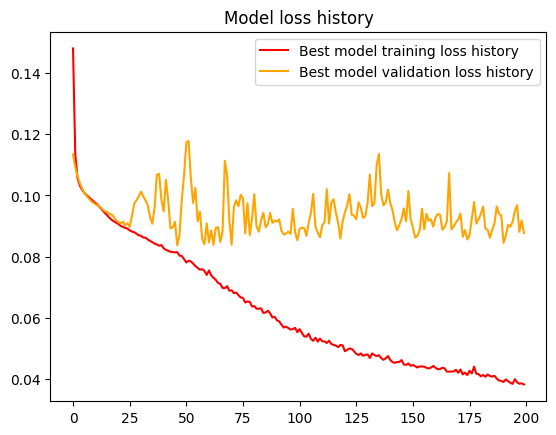

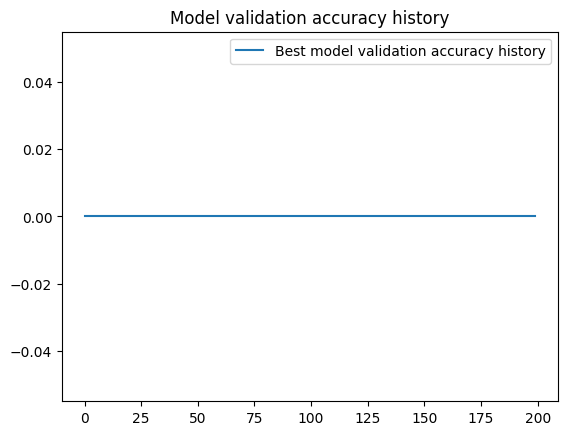


Model Training Loss: 0.03827262923121452
Model Validation Loss: 0.08772114664316177
Model Accuracy: 0.0



In [23]:
# get best model with small dataset
'''
model, model_history, _ = get_model_data(exp_params["model"]["name"])
#model = get_saved_model(model, '')
model_info = get_modelinfo('')
print("\nModel validation results")
#visualization results
vis = Visualization(model_info, model_history)
vis.get_results()
'''

In [ ]:
#model training with full dataset
exp = Experiment(exp_params["model"]["name"], ftr_dataset)
model_history = exp.train()

Running straight split
Loading saved model
	Running Epoch 21


		Running through validation set: 100%|██████████| 79/79 [00:04<00:00, 17.55it/s]


	Epoch 21 Training Loss: 0.06579308680295944
	Epoch 21 Validation Loss: 0.06901257829666138
	Epoch 21 Validation Accuracy: 0.0

	Running Epoch 26


		Running through validation set: 100%|██████████| 79/79 [00:04<00:00, 17.89it/s]


	Epoch 26 Training Loss: 0.06110843812227249
	Epoch 26 Validation Loss: 0.06874463881850243
	Epoch 26 Validation Accuracy: 0.0

	Running Epoch 31


		Running through validation set: 100%|██████████| 79/79 [00:04<00:00, 17.45it/s]


	Epoch 31 Training Loss: 0.05822146981954575
	Epoch 31 Validation Loss: 0.07502349333763123
	Epoch 31 Validation Accuracy: 0.0

	Running Epoch 36


		Running through validation set: 100%|██████████| 79/79 [00:04<00:00, 17.52it/s]


	Epoch 36 Training Loss: 0.05596498566865921
	Epoch 36 Validation Loss: 0.07532333896160126
	Epoch 36 Validation Accuracy: 0.0

	Running Epoch 41


		Running through validation set: 100%|██████████| 79/79 [00:04<00:00, 17.61it/s]


	Epoch 41 Training Loss: 0.05419880427122116
	Epoch 41 Validation Loss: 0.07334028017520905
	Epoch 41 Validation Accuracy: 0.0

	Running Epoch 46


		Running through validation set: 100%|██████████| 79/79 [00:04<00:00, 17.21it/s]


	Epoch 46 Training Loss: 0.05268986383676529
	Epoch 46 Validation Loss: 0.07314037008285522
	Epoch 46 Validation Accuracy: 0.0

	Running Epoch 51


		Running through validation set: 100%|██████████| 79/79 [00:04<00:00, 17.31it/s]


	Epoch 51 Training Loss: 0.05141235104799271
	Epoch 51 Validation Loss: 0.08780323244333267
	Epoch 51 Validation Accuracy: 0.0

	Running Epoch 56


		Running through validation set: 100%|██████████| 79/79 [00:04<00:00, 17.69it/s]


	Epoch 56 Training Loss: 0.05036197556257248
	Epoch 56 Validation Loss: 0.09229716010093689
	Epoch 56 Validation Accuracy: 0.0

	Running Epoch 61


		Running through validation set: 100%|██████████| 79/79 [00:04<00:00, 17.54it/s]


	Epoch 61 Training Loss: 0.04950292062163353
	Epoch 61 Validation Loss: 0.07636304631233215
	Epoch 61 Validation Accuracy: 0.0

	Running Epoch 66


		Running through validation set: 100%|██████████| 79/79 [00:04<00:00, 17.36it/s]


	Epoch 66 Training Loss: 0.04842335720062256
	Epoch 66 Validation Loss: 0.08095445382595062
	Epoch 66 Validation Accuracy: 0.0

	Running Epoch 71


		Running through validation set: 100%|██████████| 79/79 [00:04<00:00, 17.75it/s]


	Epoch 71 Training Loss: 0.04769347056746483
	Epoch 71 Validation Loss: 0.07460881775617599
	Epoch 71 Validation Accuracy: 0.0

	Running Epoch 76


		Running through validation set: 100%|██████████| 79/79 [00:04<00:00, 17.56it/s]


	Epoch 76 Training Loss: 0.04700237882733345
	Epoch 76 Validation Loss: 0.08089704592227936
	Epoch 76 Validation Accuracy: 0.0

	Running Epoch 81


		Running through validation set: 100%|██████████| 79/79 [00:04<00:00, 17.27it/s]


	Epoch 81 Training Loss: 0.04645245921611786
	Epoch 81 Validation Loss: 0.08044173909425735
	Epoch 81 Validation Accuracy: 0.0

	Running Epoch 86


		Running through validation set: 100%|██████████| 79/79 [00:04<00:00, 17.19it/s]


	Epoch 86 Training Loss: 0.04580308239459992
	Epoch 86 Validation Loss: 0.08021317837238312
	Epoch 86 Validation Accuracy: 0.0

	Running Epoch 91


		Running through validation set: 100%|██████████| 79/79 [00:04<00:00, 17.45it/s]


	Epoch 91 Training Loss: 0.0454313041806221
	Epoch 91 Validation Loss: 0.07675161287784577
	Epoch 91 Validation Accuracy: 0.0

	Running Epoch 96


		Running through validation set: 100%|██████████| 79/79 [00:04<00:00, 17.51it/s]


	Epoch 96 Training Loss: 0.044820106047391894
	Epoch 96 Validation Loss: 0.07871856595277786
	Epoch 96 Validation Accuracy: 0.0

	Running Epoch 101


		Running through validation set: 100%|██████████| 79/79 [00:04<00:00, 16.95it/s]


	Epoch 101 Training Loss: 0.04444236283302307
	Epoch 101 Validation Loss: 0.08344096519947052
	Epoch 101 Validation Accuracy: 0.0

	Running Epoch 106


		Running through validation set: 100%|██████████| 79/79 [00:04<00:00, 17.78it/s]


	Epoch 106 Training Loss: 0.04397606272101402
	Epoch 106 Validation Loss: 0.07841594154834747
	Epoch 106 Validation Accuracy: 0.0

	Running Epoch 111


		Running through training set:  92%|█████████▏| 287/313 [00:41<00:03,  6.93it/s]

In [ ]:
# get best model
model, model_history, _ = get_model_data(exp_params["model"]["name"])
#model = get_saved_model(model, '')
model_info = get_modelinfo('')

print("\nModel validation results")
#visualization results
vis = Visualization(model_info, model_history)
vis.get_results()



Testing Saved Model


<Figure size 640x480 with 0 Axes>

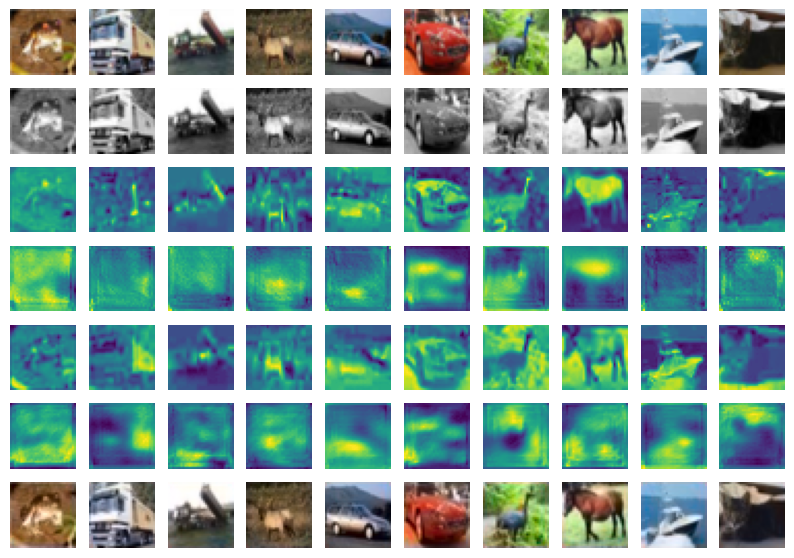


Test Loss: 0.050770603120326996
Test Accuracy: tensor(0.) 



In [24]:
#model testing with small subset of training dataset
model = get_model(exp_params["model"]["name"])
model.load_state_dict(torch.load("models/checkpoints/last_model.pt", map_location = torch.device(config["device"])))
print("\n\nTesting Saved Model")
mt = ModelTester(model, smftrte_dataset)
mt.test_and_plot(ds["RGBtr"], ABtr, "best_model", True)



Testing Saved Model


<Figure size 640x480 with 0 Axes>

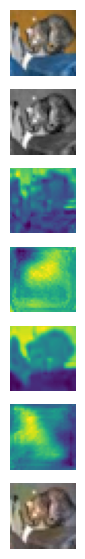


Test Loss: 0.12071332335472107
Test Accuracy: tensor(0.) 



In [25]:
#model testing with small test data
model = get_model(exp_params["model"]["name"])
model.load_state_dict(torch.load("models/checkpoints/last_model.pt", map_location = torch.device(config["device"])))
print("\n\nTesting Saved Model")
mt = ModelTester(model, smfte_dataset)
mt.test_and_plot(ds["RGBte"], ABte, "best_model", True)

In [ ]:
#model testing with whole test data
'''
model = get_model(exp_params["model"]["name"])
model.load_state_dict(torch.load("models/checkpoints/last_model.pt", map_location = torch.device(config["device"])))
print("\n\nTesting Saved Model")
mt = ModelTester(model, te_dataset)
mt.test_and_plot(ds["RGBte"], ABte, "best_model", True)
'''